In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
%matplotlib inline
from tqdm.auto import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### "Хороший" студент :  относительное количество работ, проверенных более, чем за n часов < 0.1
### Студенты "первого" рода:  "хорошие" студенты, которые не закончили курс
### Студенты "второго" рода:  "плохие" студенты, которыеё закончили курс

In [ ]:
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]

def prepare_dataframe(subject,course_id):
    
    """
    возвращает таблицу с колонками: element_progress_id, hours_diff, user_id, module_is_achieved
    """
    
    path = f'courses_with_manual_check/{subject}/{course_id}/'
    try:
        solution_log = pd.read_csv(path+'solution_log.csv')
    except:
        raise Exception(f'No such file or directory',path,'solution_log.csv')
        
    solution_log = solution_log.dropna(subset=['review_time'])
    solution_log = solution_log.reset_index(drop=True)
    
    ###
    difference = []
    for i in range(len(solution_log['review_time'])):
        a = datetime.strptime(magic(solution_log['submission_time'][i]), '%Y %m %d %H:%M:%S')
        b = datetime.strptime(magic(solution_log['review_time'][i]), '%Y %m %d %H:%M:%S')
        difference.append(b - a)
    solution_log['time_of_expectation'] = difference
    solution_log = solution_log.drop(columns=['submission_time', 'review_time'])
    ###
    
    solution_log['hours_diff']=solution_log['time_of_expectation'].apply(lambda x: x.days*24+x.seconds//3600)
    pre_df = solution_log[['element_progress_id','hours_diff']]
    pre_df['id']=pre_df['element_progress_id'].astype(int)
    pre_df = pre_df.drop(columns=['element_progress_id'])
    try:
        user_element_progress = pd.read_csv(path+'user_element_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_element_progress.csv')
    user_element_progress['id'] = user_element_progress['id'].astype(int)
    user_element_progress.reset_index(drop=True)
    user_element_progress = user_element_progress[['id','user_id']]
    
    try:
        user_module_progress = pd.read_csv(path+'user_module_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_module_progress.csv')
    user_module_progress['is_achieved'] = user_module_progress['is_achieved'].fillna(False).astype(int)
    user_module_progress = user_module_progress[['user_id','is_achieved']]
    
    
    df = pre_df.merge(user_element_progress).merge(user_module_progress, on='user_id').drop(columns='id')
    return df

def hours_criterion(subject,course_id,h_start=0, h_end=96,df=None, show_good_bad=True):
    """
    Построение графика относитльно часов
    """
    if df is None:
        df = prepare_dataframe(subject, course_id)
    if h_start>=h_end:
        raise Exception(f'h_start>=h_end')
    
    hours = np.arange(h_start,h_end)
    if show_good_bad:
        good = []
        bad = []
    I_error = []
    II_error = []
 
    for h in tqdm(hours):
        if show_good_bad: 
            g = 0
            b = 0
        I_type = 0
        II_type = 0
        for u_id in df['user_id'].unique():
            total = len(df[df['user_id']==u_id])
            greater =  sum((df[df['user_id']==u_id]['hours_diff']>h))/total
            if greater<=0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==0:
                I_type+=1   
            elif greater>0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1:
                II_type+=1
            elif show_good_bad:
                if greater<=0.1 and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1: 
                    g+=1
                else:
                    b+=1
        I_error.append(I_type)
        II_error.append(II_type)
        if show_good_bad:
            good.append(g)
            bad.append(b)
    
    total_passed = df.groupby(['user_id'])['is_achieved'].min().sum()
    total_students = len(df['user_id'].unique())
    not_w_error = max(I_error)+max(II_error)
    w_error = not_w_error
    not_w_h = None
    w_h = None
    for i in range(len(hours)):
        #проверка, что никакая из ошибок не равна 1/0(в абсолютном значении)
        if (I_error[i]!=total_students-total_passed and II_error[i]!=total_passed) and  (II_error[i]!=0 and I_error[i]!=0): 
            if I_error[i]+II_error[i]<not_w_error:
                not_w_error=I_error[i]+II_error[i]
                not_w_h = hours[i]
            if I_error[i]/(total_students-total_passed)+II_error[i]/total_passed<w_error:
                w_error=I_error[i]/(total_students-total_passed)+II_error[i]/total_passed
                w_h = hours[i]
    print(f"Минимальное время проверки: {df['hours_diff'].min()} часов, максимальное время проверки {df['hours_diff'].max()} часов")
    print(f'Лучшее "невзвешенное" время: {not_w_h} (ошибка {not_w_error}, из них {I_error[not_w_h]} первого рода),'
                     f' лучшее взвешенное время: {w_h} (ошибка {w_error}, из этого {I_error[w_h]/(total_students-total_passed)} первого рода')
    print(f'Ошибка для {hours[48]} часов: {I_error[48]+II_error[48]}, взвешенная: {I_error[48]/(total_students-total_passed)+II_error[48]/total_passed}')
    I_error = np.array(I_error)/(total_students-total_passed) 
    II_error = np.array(II_error)/total_passed
    if show_good_bad:
        good = np.array(good)/total_passed
        bad = np.array(bad)/(total_students-total_passed)
    
    fig, axis = plt.subplots(1,1,figsize=(20,7))
    if show_good_bad:
        axis.plot(hours, bad, label='"bad" students',color='r')
        axis.plot(hours, good, label = '"Good" students', color='g')
    
    axis.plot(hours, I_error, label ='"I type error" students')
    axis.plot(hours, II_error, label = '"II type error" students')

    axis.vlines(48,0,1,'black', label = '48 hours')
    axis.vlines(w_h,0,1,'cyan', label = 'best weighted')
    axis.vlines(not_w_h,0,1,'purple', label = 'best not weighted')
    plt.legend(fontsize=14)
    axis.set_title(f'{subject}-{course_id}')
    axis.set_xlabel('hours')
    axis.set_ylabel('relative amount')
    plt.show()
    
    
def fraction_criterion(subject,course_id,f_start=0, f_end=1.1, step=0.05):
    """
    Построение графика относитльно доли работ, проверенных больше, чем за 48 часов
    """
    df = prepare_dataframe(subject, course_id)
    if f_start>=f_end:
        raise Exception(f'f_start>=f_end')
    fractions = np.arange(f_start,f_end,step)
    good = []
    I_error = []
    II_error = []
    bad = []
    for f in tqdm(fractions):
        g = 0
        I_type = 0
        II_type = 0
        b = 0
        for u_id in df['user_id'].unique():
            total = len(df[df['user_id']==u_id])
            greater =  sum((df[df['user_id']==u_id]['hours_diff']>=48))/total
            if greater<f and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1: 
                g+=1
            elif greater<f and df[df['user_id']==u_id]['is_achieved'].iloc[0]==0:
                I_type+=1   
            elif greater>=f and df[df['user_id']==u_id]['is_achieved'].iloc[0]==1:
                II_type+=1
            else:
                b+=1
        good.append(g)
        I_error.append(I_type)
        II_error.append(II_type)
        bad.append(b)
    
    total_passed = df.groupby(['user_id'])['is_achieved'].min().sum()
    total_students = len(df['user_id'].unique())
    good = np.array(good)/total_passed
    I_error = np.array(I_error)/(total_students-total_passed) 
    II_error = np.array(II_error)/total_passed
    bad = np.array(bad)/(total_students-total_passed)
    fig, axis = plt.subplots(1,1,figsize=(20,7))
    axis.plot(fractions, good, label = '"Good" students', color='g')
    axis.plot(fractions, I_error, label ='"I type error" students')
    axis.plot(fractions, II_error, label = '"II type error" students')
    axis.plot(fractions, bad, label='"bad" students',color='r')
    plt.legend(fontsize=14)
    axis.set_title(f'{subject}-{course_id}')
    axis.set_xlabel('fraction')
    axis.set_ylabel('relative amount')
    plt.show()

### $ \{T_{i} > t \text{ часов } \} \le 0.1 $

  0%|          | 0/72 [00:00<?, ?it/s]

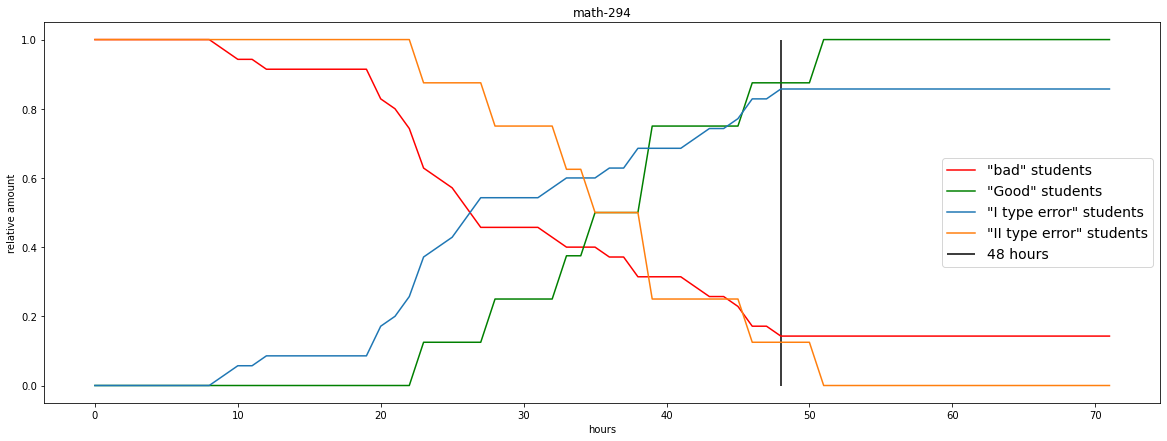

Минимальное время проверки: 0 часов, максимальное время проверки 274 часов


In [32]:
hours_criterion('math','294',0, 72)

### $ \{T_{i} \ge 48 \text{ часов } \} < f $

  0%|          | 0/22 [00:00<?, ?it/s]

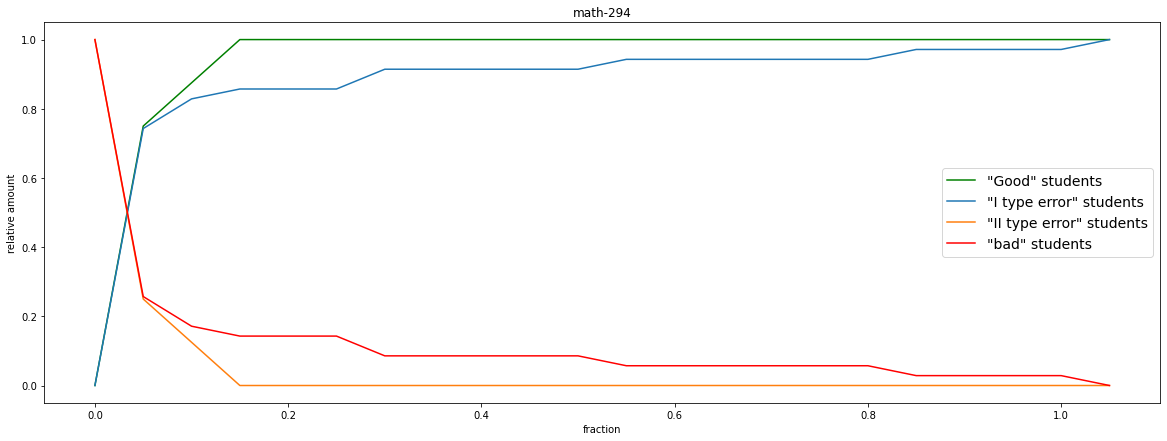

In [33]:
fraction_criterion('math','294')

In [4]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(s[1],c)
            for i in tmp_df['user_id'].unique():
                try:
                    if i in df['user_id'].unique():
                        print('Alarm',i,s[1],c)
                except:
                    pass
            df=df.append(tmp_df,ignore_index=True)
df

Alarm 100120090110736982 physics 345


,hours_diff,user_id,is_achieved
0,33,100119750111014140,0
1,21,100119750111014140,0
2,43,100119750111014140,0
3,21,100119750111014140,0
4,22,100119750111014140,0
...,...,...,...
8850,14,100120030110010958,0
8851,22,100120030110010958,0
8852,43,100120040110672072,0
8853,3,100120040110672072,0


In [5]:
df[df['user_id']==100120090110736982]['is_achieved'].value_counts()

0    58
Name: is_achieved, dtype: int64

In [35]:
len(df['user_id'].unique())

300

In [32]:
df.groupby(['is_achieved']).agg({"user_id": "nunique"})

,user_id
is_achieved,
0,205
1,95


In [5]:
hours_criterion('All','coursers',df=df)

 33%|███▎      | 32/96 [00:09<00:19,  3.35it/s]


KeyboardInterrupt: 

100%|██████████| 96/96 [00:26<00:00,  3.58it/s]

Минимальное время проверки: 0 часов, максимальное время проверки 2536 часов
Лучшее "невзвешенное" время: 16 (ошибка121, из них 27 первого рода), лучшее взвешенное время: 88 (ошибка 1.0572528883183567, из этого 0.9414634146341463 первого рода
Ошибка для 48 часов: 183, взвешенная: 1.1242618741976893


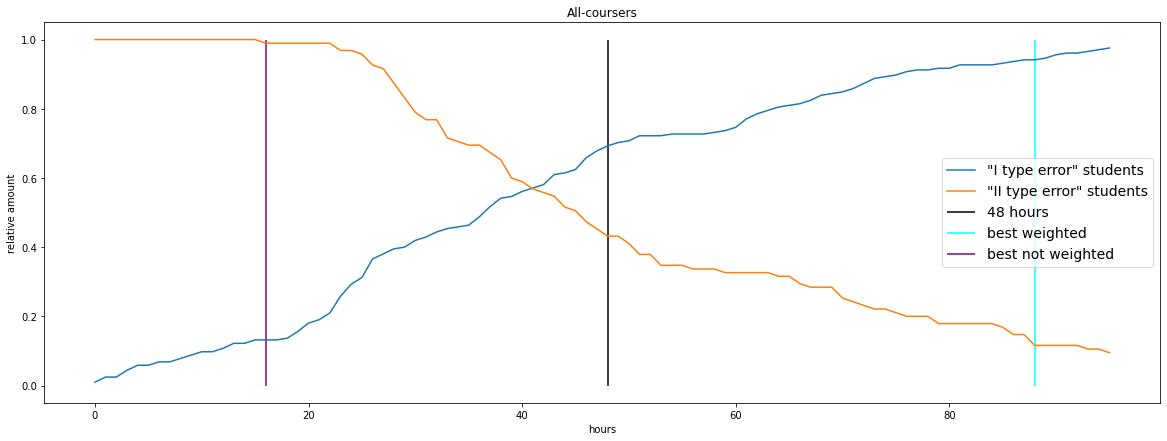

In [38]:
hours_criterion('All','coursers',df=df, show_good_bad=False)